# Training a Deep Neural Network on MNIST dataset and finding optimal parameter values

## Setup

In [39]:
import numpy as np
np.random.seed(42)

import tensorflow as tf
from tensorflow import keras

%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd

## Getting the data and splitting it

In [41]:
import os
DIGITS_PATH = '../datasets/digit-recognizer'

def load_digits(digits_path=DIGITS_PATH, test=False):
  csv_path = os.path.join(digits_path, 'test.csv' if test else 'train.csv')
  return pd.read_csv(csv_path)

In [43]:
data = load_digits()


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
X_train_full = data.drop('label', axis=1).to_numpy().reshape(42000, 28, 28)
y_train_full = data['label'].to_numpy()

In [3]:
# dividing every image with 255 to put pixel values between 0 - 1
X_train, X_valid = X_train_full[5000:] / 255.0, X_train_full[:5000] / 255.0
y_train, y_valid = y_train_full[5000:], y_train_full[:5000] / 255.0

## Seeing the data

3

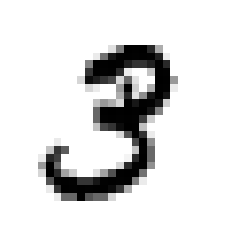

In [57]:
plt.imshow(X_train[1], cmap='binary')
plt.axis('off')
y_train[1]

In [5]:
def show_pictures(n_rows, n_cols, pictures, titles):
  plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
  for row in range(n_rows):
    for col in range(n_cols):
      index = n_cols * row + col
      plt.subplot(n_rows, n_cols, index + 1)
      plt.imshow(pictures[index], cmap='binary', interpolation='nearest')
      plt.axis('off')
      plt.title(titles[index], fontsize=12)
  plt.subplots_adjust(wspace=0.2, hspace=0.5)
  plt.show()

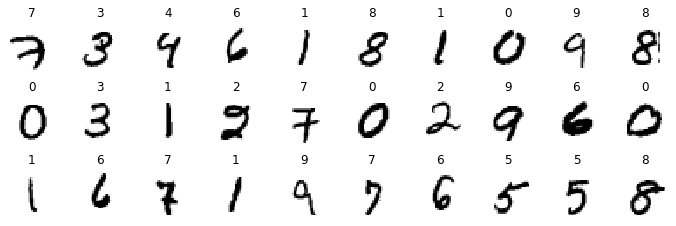

In [58]:
show_pictures(3, 10, X_train, y_train)

In [59]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
  def __init__(self, factor):
    self.factor = factor
    self.rates = []
    self.losses = []
  def on_batch_end(self, batch, logs):
    self.rates.append(K.get_value(self.model.optimizer.learning_rate))
    self.losses.append(logs['loss'])
    K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

In [60]:
keras.backend.clear_session()
tf.random.set_seed(42)

In [61]:
model = keras.models.Sequential([
  keras.layers.Flatten(input_shape=[28, 28]),
  keras.layers.Dense(300, activation='relu'),
  keras.layers.Dense(100, activation='relu'),
  keras.layers.Dense(10, activation='softmax')
])

In [62]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=['accuracy'])
expon_lr = ExponentialLearningRate(factor=1.005)

In [63]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

1719/1719 [==============================] - 6s 3ms/step - loss: 65477976.0000 - accuracy: 0.5858 - val_loss: 2.4284 - val_accuracy: 0.0000e+00


Text(0, 0.5, 'Loss')

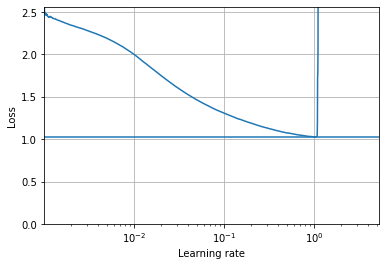

In [64]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid(True)
plt.xlabel('Learning rate')
plt.ylabel('Loss')

Loss shoots upwards when the learning rate goes over 0.6 so we will set it to half that 0.3.

In [65]:
keras.backend.clear_session()
tf.random.set_seed(42)

In [66]:
model = keras.models.Sequential([
  keras.layers.Flatten(input_shape=[28, 28]),
  keras.layers.Dense(300, activation='relu'),
  keras.layers.Dense(100, activation='relu'),
  keras.layers.Dense(10, activation='softmax')
])

In [67]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=0.3),
              metrics=['accuracy'])

In [68]:
run_index = 1
run_logdir = '../keras/logs/digit-recognizer/run_' + str(run_index)
run_logdir

'../keras/logs/digit-recognizer/run_1'

In [69]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint('../keras/models/digits_model.h5', save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2364 - accuracy: 0.9260 - val_loss: 11.2206 - val_accuracy: 0.0952
Epoch 2/100
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0938 - accuracy: 0.9706 - val_loss: 12.7213 - val_accuracy: 0.0954
Epoch 3/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0669 - accuracy: 0.9790 - val_loss: 15.9717 - val_accuracy: 0.0952
Epoch 4/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0482 - accuracy: 0.9847 - val_loss: 18.0022 - val_accuracy: 0.0944
Epoch 5/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0362 - accuracy: 0.9883 - val_loss: 19.0765 - val_accuracy: 0.0944
Epoch 6/100
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0300 - accuracy: 0.9900 - val_loss: 19.4494 - val_accuracy: 0.0946
Epoch 7/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0227 - accuracy: 0.9921 - val_loss: 21.8121 -

In [70]:
model = keras.models.load_model('../keras/models/digits_model.h5')

In [75]:
test_data = load_digits(test=True).to_numpy()
test_data = test_data.reshape(test_data.shape[0], 28, 28)

In [78]:
predictions = model.predict(test_data).argmax(axis=-1)

In [82]:
submission = pd.DataFrame(data={'ImageId': range(1, len(test_data) + 1), 'Label': predictions})
submission.to_csv(str(run_index) + '_submission.csv', index=False)